In [1]:
from __future__ import division, print_function
%matplotlib inline
from utils import *
from keras.layers.merge import dot, add, concatenate
from pandas_summary import DataFrameSummary
import seaborn as sns
import sys
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Using TensorFlow backend.


# StuffMyFridge: A Grocery Product Recommender

The goal of this notebook is to build a grocery product recommendation system for users of the Instacart app. Instacart is a company that deliveres groceries from local stores. We will use “The Instacart Online Grocery Shopping Dataset 2017”, which can be found in https://www.instacart.com/datasets/grocery-shopping-2017.

Here is the data description: 

`orders` (3.4m rows, 206k users, 109 MB):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows, 2.2 MB):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows, 2.6 kB):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`departments` (21 rows, 270 bytes):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders, 577.6 MB)
* `"train"`: training data supplied to participants (~131k orders, 24.7 Mb)

## Set up data

Read data:

In [2]:
order_products_prior_df =  pd.read_csv('data/order_products__prior.csv', engine='c',  
                                       dtype={'order_id': np.int32, 'product_id': np.int32,
                                              'add_to_cart_order': np.int16, 'reordered': np.int8})

order_products_train_df = pd.read_csv('data/order_products__train.csv', engine='c',  
                                      dtype={'order_id': np.int32, 'product_id': np.int32, 
                                      'add_to_cart_order': np.int16, 'reordered': np.int8})

orders_df = pd.read_csv('data/orders.csv', engine='c', 
                        dtype={'order_id': np.int32, 'user_id': np.int32, 'order_number': np.int32,
                       'order_dow': np.int8, 'order_hour_of_day': np.int8, 'days_since_prior_order': np.float16})

products_df = pd.read_csv("data/products.csv", engine='c')

aisles_df = pd.read_csv("data/aisles.csv", engine='c')

departments_df = pd.read_csv("data/departments.csv", engine='c')

Define dicts to go from ids to names and vice-versa

In [3]:
aisles_id2name = pd.Series(aisles_df.aisle.values, index=aisles_df.aisle_id).to_dict()
prodid2aisle = pd.Series(products_df.aisle_id.values, index=products_df.product_id).to_dict()

Useful info about dataset:

Total number of products: 49677
Total number of users: 206209
Total number of orders placed: 3421083
Total number of products ordered: 32434489
Average number of products per order: 9
Number of products per aisle (top 10):


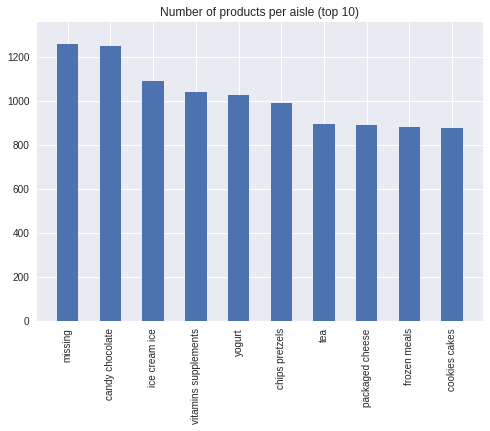

In [4]:
print('Total number of products: {}'.format(order_products_prior_df.product_id.unique().shape[0]))
print('Total number of users: {}'.format(orders_df.user_id.unique().shape[0]))
print('Total number of orders placed: {}'.format(orders_df.shape[0]))
print('Total number of products ordered: {}'.format(order_products_prior_df.shape[0]))
print('Average number of products per order: {}'.format(round(order_products_prior_df.shape[0]/orders_df.shape[0])))

prod_aisle_dist = products_df.groupby('aisle_id')['product_name'].count().sort_values(ascending=False)
num_prods_per_aisle_sorted = list(zip(map(aisles_id2name.get, prod_aisle_dist.index), prod_aisle_dist.values ))
print('Number of products per aisle (top 10):')
dic = OrderedDict({x:y for x,y in num_prods_per_aisle_sorted[:10]})

X = np.arange(len(dic))
plt.bar(X, dic.values(), align='center', width=0.5)
plt.xticks(X, dic.keys(), rotation = 90)
ymax = max(dic.values()) + 100
plt.ylim(0, ymax)
plt.title('Number of products per aisle (top 10)')
plt.show()

Collect order and product info for each user and merge into a data frame df

In [5]:
df_train = orders_df.merge(order_products_train_df, how = 'inner', on = 'order_id')
df_train = df_train.merge(products_df, how = 'inner', on = 'product_id')
df_train.sort_values(['user_id', 'order_number'], axis=0, inplace=True)

In [6]:
df_prior = orders_df.merge(order_products_prior_df, how = 'inner', on = 'order_id')
df_prior = df_prior.merge(products_df, how = 'inner', on = 'product_id')
df_prior.sort_values(['user_id', 'order_number'], axis=0, inplace=True)

In [7]:
df = pd.concat([df_prior, df_train])

In [8]:
#fillna
df.fillna(0,axis=0, inplace=True)
df.drop('eval_set', axis=1, inplace = True)
df.reset_index(drop = True, inplace = True)
del df_train, df_prior

In [9]:
#sample=int(1e7)
#df = df.iloc[:sample]

In [9]:
df.head(3)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2539329,1,1,2,8,0.0,196,1,0,Soda,77,7
1,2539329,1,1,2,8,0.0,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16
2,2539329,1,1,2,8,0.0,12427,3,0,Original Beef Jerky,23,19


## Product Rating per User

Users did not rate products but we can figure how often a user bought a given product and then use this as a proxy for a rating score. 

In [11]:
#drop the products that were never 'reodered'
#df = df[df['reordered']!=0]

In [11]:
#group by user_id and order_number (this takes ~4 minutes to run locally on the entire data set).
#X = df.groupby(['user_id', 'order_number'])['product_id'].apply(lambda x : list(x)).reset_index()
#X.columns = ['user_id', 'order_number', 'product_list']

In [12]:
#now group by user_id 
#X_users =X.groupby('user_id')['product_list'].apply(lambda x : list(x)).reset_index()
#X_users['num_orders_per_user'] = X_users.product_list.map(len)
#X_users['ave_num_prods_per_order'] = X_users.product_list.map(lambda L: [len(x) for x in L]).map(np.mean).map(round)
#X_users.set_index('user_id',inplace = True)

Update product and user ids so that they are contiguous integers, which we want when using embeddings.

In [10]:
g=df.groupby(['user_id','product_name','product_id'])

#create prod_rating df and add a product_count feature (i.e. how many times has the user reordered the product)
prod_ratings = g['reordered'].count().reset_index()
prod_ratings.columns = ['user_id', 'product_name', 'product_id', 'product_count']

In [11]:
users = prod_ratings.user_id.unique()
prods = prod_ratings.product_id.unique()

userid2idx = {o:i for i,o in enumerate(users)}
prodid2idx = {o:i for i,o in enumerate(prods)}

prod_ratings.product_id = prod_ratings.product_id.apply(lambda x: prodid2idx[x])
prod_ratings.user_id = prod_ratings.user_id.apply(lambda x: userid2idx[x])

In [13]:
#number of users and products in sample
n_users = prod_ratings.user_id.nunique()
n_prods = prod_ratings.product_id.nunique()
print(n_users, n_prods)

206209 49685


Here is a function that plots the product count distribution for a given user (top 10)

In [14]:
def product_dist(u_id):
    '''Plot the product count distribution for a given user (top 10)'''
    user_data = prod_ratings[prod_ratings.user_id==u_id]
    sorted_tuple = sorted(zip(user_data.product_name, user_data.product_count), key =itemgetter(1), reverse = True)
    user_dict = OrderedDict(sorted_tuple[:10])
    x = np.arange(len(user_dict))
    plt.bar(x, user_dict.values(), align='center', width=0.5)
    plt.xticks(x, user_dict.keys(), rotation = 90)
    ymax = max(user_dict.values()) + 1
    plt.ylim(0, ymax)
    plt.title('Product count distribution for user 0 (top 10 only)')
    plt.show()

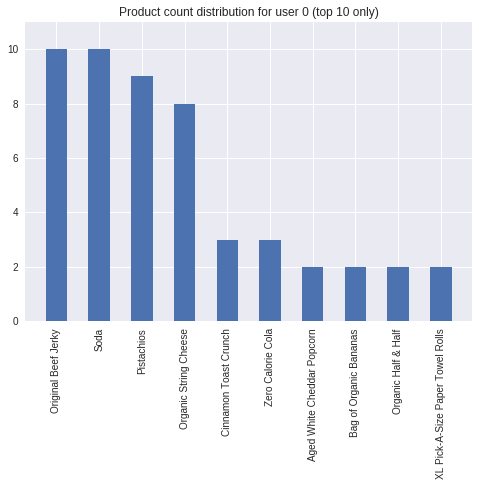

,user_id,product_name,product_id,product_count
0,0,0% Greek Strained Yogurt,0,1
1,0,Aged White Cheddar Popcorn,1,2
2,0,Bag of Organic Bananas,2,2
3,0,Bartlett Pears,3,1
4,0,Cinnamon Toast Crunch,4,3


In [16]:
product_dist(0)
prod_ratings.head()

Define star (1-5) and binary (0 or 1) rating and then apply them to the 'product_count' column  to get 'product_rating'.

In [15]:
def round_rating(number):
    "round to the nearest half integer"
    return np.round(number*2)/2
    
def counts_to_range(counts):
    '''Transforms user's product count to a given range (1, 5).'''
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(1, 5))
    scaled = scaler.fit_transform(counts)    
    return round_rating(scaled)

def counts_to_binary(counts):
    '''Transforms user's product count to a binary scale (1 if product was bought once or more, 0 otherwise).'''
    return np.where(counts>0, 1, 0)

#apply rating_func to each user and concatenate results'''
#dfs = prod_ratings.groupby('user_id')['product_count'].apply(counts_to_range)
#prod_ratings['product_score'] = np.concatenate(np.array(dfs))

In [16]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler

mapper = DataFrameMapper([('product_count', MinMaxScaler())], df_out=True)

#apply the mapper to each user and concatenate results
dfs = [np.round(mapper.fit_transform(prod_ratings[prod_ratings.user_id==u].copy()), 1) for u in range(n_users)]  

prod_ratings['product_score'] = pd.concat(dfs).reset_index(drop=True)*4 + 1
prod_ratings['product_score'] = round_rating(prod_ratings['product_score'])
prod_ratings.head()

/home/paperspace/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


,user_id,product_name,product_id,product_count,product_score
0,0,0% Greek Strained Yogurt,0,2,1.5
1,0,Aged White Cheddar Popcorn,1,3,2.0
2,0,Bag of Organic Bananas,2,2,1.5
3,0,Bartlett Pears,3,1,1.0
4,0,Cinnamon Toast Crunch,4,4,2.0


Let us create a crosstab from the top 10 users and the top 10 products

In [17]:
g=prod_ratings.groupby('user_id')['product_score'].count()
topUsers=g.sort_values(ascending=False)[:10]

g=prod_ratings.groupby('product_name')['product_score'].count()
topProds=g.sort_values(ascending=False)[:10]

top_r = prod_ratings.join(topUsers, rsuffix='_r', how='inner', on='user_id')
top_r = top_r.join(topProds, rsuffix='_r', how='inner', on='product_name')

In [18]:
pd.crosstab(top_r.user_id, top_r.product_name, top_r.product_score, aggfunc=np.sum)

product_name,Bag of Organic Bananas,Banana,Large Lemon,Limes,Organic Avocado,Organic Baby Spinach,Organic Blueberries,Organic Hass Avocado,Organic Strawberries,Strawberries
user_id,,,,,,,,,,
15123,1.0,3.0,3.0,2.0,1.5,1.0,1.0,1.5,2.5,2.5
31309,NaN,2.0,5.0,2.5,NaN,NaN,NaN,NaN,NaN,2.0
75303,NaN,3.5,2.0,1.0,NaN,NaN,NaN,NaN,NaN,1.5
116570,NaN,4.0,NaN,NaN,NaN,2.0,1.0,NaN,NaN,4.0
143960,NaN,NaN,NaN,NaN,1.0,5.0,NaN,NaN,1.0,1.5
151993,1.0,2.0,4.5,2.0,NaN,NaN,1.0,2.0,1.0,2.0
152143,3.5,2.5,1.0,1.0,NaN,4.0,1.0,NaN,1.5,3.0
181208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0
182400,5.0,NaN,2.0,1.5,1.0,4.0,1.0,2.5,2.5,1.0


Randomly split into training and validation.

In [21]:
np.random.seed = 42
msk = np.random.rand(len(prod_ratings)) < 0.9
trn = prod_ratings[msk]
val = prod_ratings[~msk]

##  Simple dot product model using embeddings in Keras

In [22]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(input_dim=n_in, output_dim=n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [23]:
#number of latent factors 
n_factors = 50

#get embedding inputs
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-2)
prod_in, p = embedding_input('prod_in', n_prods, n_factors, 1e-2)

In [24]:
def create_bias(inp, n_in):
    x = Embedding(input_dim=n_in, output_dim=1, input_length=1)(inp)
    return Flatten()(x)

In [25]:
ub = create_bias(user_in, n_users)
pb = create_bias(prod_in, n_prods)

In [26]:
from keras import backend
from keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    '''Define Root Mean Squared Error as our custom metric'''
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0)]

x = dot([u, p], axes=2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, pb])
model = Model([user_in, prod_in], x)
model.compile(Adam(0.1), loss='mse', metrics=[rmse])

history = model.fit([trn.user_id, trn.product_id], trn.product_score, batch_size=64, epochs=4, 
          validation_data=([val.user_id, val.product_id], val.product_score), callbacks=callbacks)
plt.plot(history.history['val_loss'])

Train on 326878 samples, validate on 81934 samples
Epoch 1/4
223744/326878 [===================>..........] - ETA: 59s - loss: 2.5612 - rmse: 1.1229

KeyboardInterrupt: 

In [138]:
model.save_weights('models/simplemodel.h5')

In [42]:
model.load_weights('models/simplemodel.h5')

Helper function to predict new product scores

In [40]:
def predictions(u_id, p_id):
    '''create a product_name:product_score dictionary '''
    return (prod_id2name[p_id], np.round(model.predict([np.array([u_id]), np.array([p_id])]))[0][0])

Recommend a list of product to a given user, using the top predicted product_scores

In [41]:
def user_recommendation(u_id):
    '''recommend 20 new products to user'''
    
    #exclude products the user has already bought
    prods_to_rate = list(set(prod_ratings.product_id) - set(prod_ratings[prod_ratings.user_id==u_id].product_id))
    
    #predict the ratings for new unseen products
    scores = {predictions(u_id,p)[0]:predictions(u_id,p)[1] for p in prods_to_rate}
    
    return list(OrderedDict(sorted(scores.items(), key =itemgetter(1), reverse = True)))[:20]

In [44]:
user_recommendation(0)

['Pure Almond Unsweetened Original Almond Milk',
 'Everything Bagel',
 'Burrata Mozzarela Cheese',
 'Just Green Unsweetened Tea',
 'Authentic French Brioche',
 'New Orleans Iced Coffee',
 'Frozen Desserts, Cookies and Cream',
 'Lager',
 'Perfectouch Grab N Go Cups With Lids',
 'Lemon Seltzer Water',
 '80  Vodka Holiday Edition',
 'Natural Lime Flavor Sparkling Mineral Water',
 'Vegetable Classics Green Split Pea Soup',
 'Chocolate Milk 1% Milkfat',
 'Mini Classic Ice Cream',
 'Hand Dipped Basket Whole Milk Ricotta',
 'Organic Heritage Flakes Cereal',
 'Milk Chocolate Covered Frozen Banana',
 'Whipped Mixed Berry Tub',
 'Santa Fe Fiesta Salad',
 'Thousand Island Salad Snax',
 'Anejo Tequila',
 'Goat Milk',
 'DanActive Vanilla Probiotic Dairy Drink',
 'Half Tea & Half Lemonade',
 'Organic Power Greens',
 'Dishwasher Detergent',
 'Dolmas',
 'Caramel with Almond Milk Iced Coffee',
 'Greek Yogurt 0% Fat Plain']

## Analyze results

For simplicity, we restrict the analysis to the top 2000 most popular products.

In [98]:
g=prod_ratings.groupby('product_id')['product_score'].count()
topProds=g.sort_values(ascending=False)[:2000]
topProds = np.array(topProds.index)

In [99]:
topProds

array([  23,    2,  141, ..., 5398, 5355, 4011])

Let us first look at the product bias term. We create a model using the functional API. Our input is the product id and the output is the product bias term.

In [100]:
prod_names = prod_ratings['product_name'].to_dict

In [101]:
#top product is banana
prod_names()[topProds[0]]

'Baked Organic Sea Salt Crunchy Pea Snack'

In [103]:
get_prod_bias = Model(prod_in, pb)
prod_bias = get_prod_bias.predict(topProds)
product_ratings = [(b[0], prod_names()[prod_ratings.product_id[i]]) for i,b in zip(topProds,prod_bias)]

TypeError: __call__() takes 2 positional arguments but 3 were given

Now we can look at the top and bottom rated products. These ratings take into account user sentiment, as well as different types of producst that different users reorder.

In [49]:
sorted(product_ratings, key=itemgetter(0))[:15]


[(-12.260419, 'Balsamic Vinegar Of Modena'),
 (-12.254536, 'Electrolyte Water'),
 (-11.362408, 'Banana'),
 (-11.015893, 'Sparkling Peach'),
 (-10.818048, 'Organic Bunch Beets'),
 (-10.793405, 'PlusShot Blueberry Acai Probiotic Juice Drink'),
 (-10.363061, 'Jalapeno Peppers'),
 (-10.295506, 'Beef Flavor Top Ramen'),
 (-10.130666, 'Roma Tomato'),
 (-9.8693409, 'Truffle Parmesan Macaroni & Cheese Bowl'),
 (-9.8534021, 'Canned Aranciata Orange'),
 (-9.7313662, 'Chili Sauce'),
 (-9.6588259, 'Roasted Red Pepper Hummus'),
 (-9.6164093, 'Organic Roma Tomato'),
 (-9.5881796, 'Reclosable Sandwich Bags')]

In [50]:
sorted(product_ratings, key=itemgetter(0), reverse=True)[:15]

[(22.147203, 'Potato Chips Cheddar & Sour Cream Flavored Party Size!'),
 (20.278847, 'Dairy Pure Heavy Whipping Cream'),
 (19.12274, 'Citrus + Mint'),
 (18.937477, 'Mini Double Caramel Ice Cream Bars'),
 (17.414837, '100% Whole Wheat Bread'),
 (17.263594, 'Garlic'),
 (16.503759, 'Feta Cheese Crumbles'),
 (16.435913, 'Creamy Peanut Butter'),
 (15.88129, '12 Oz Lager'),
 (15.265867, 'Organic Whole Grain Wheat English Muffins'),
 (14.064123, 'Pita Chips, Simply Naked'),
 (13.671357, 'Strawberry Ice Cream'),
 (13.486944, 'Green Tea Green Ginger Tea Bags'),
 (13.267944, 'Unsweetened Watermelon Water'),
 (12.929931, 'Strawberry Cheesecake Ice Cream')]

We can now do the same thing for the embeddings.

In [51]:
get_prod_emb = Model(prod_in, p)
prod_emb = np.squeeze(get_prod_emb.predict([topProds]))
prod_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
prod_pca = pca.fit(prod_emb.T).components_

In [53]:
fac0 = prod_pca[0]

In [54]:
prod_comp = [(f, prod_names()[prod_ratings.product_id[i]]) for f,i in zip(fac0, topProds)]

Here's the 1st component. Hard to tell what these features represent...

In [68]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.77194913478691962, 'Regular Pork Sausage Tube'),
 (-0.21088083492249446, 'Vanilla Coke'),
 (-0.12160985720519842, 'Natural Monterey Jack Cheese'),
 (-0.11564633881408577, 'Goat Cheese Log'),
 (-0.11464596686377114, 'Gluten Free Pretzel Sticks'),
 (-0.076984518970863058, 'White Distilled Vinegar'),
 (-0.062745999765025193, 'Vegetable Lasagna'),
 (-0.058988514424249065, 'White English Muffins'),
 (-0.048447304447711531, 'Diced Tomatoes'),
 (-0.043709688997337674, 'Naturally Hickory Smoked Thick Cut Bacon')]

In [69]:
sorted(prod_comp, key=itemgetter(0),reverse=True)[:10]

[(0.3212293673025598, 'The Original Worcestershire Sauce'),
 (0.23003288058576157, 'Snacks String Cheese Natural Mozzarella Cheese'),
 (0.19252063340850084, 'Mediterranean Mint Gelato'),
 (0.13872596091071723,
  "Blasts! Reese's Peanut Butter Cups Frozen Dairy Dessert"),
 (0.11818800123157888, 'Total 0% Nonfat Greek Yogurt'),
 (0.10284608272032775, 'Organic Rosemary'),
 (0.087100174687347959, 'Organic Hass Avocado'),
 (0.078506096765528721, 'Iced Tea with Peach Liquid Water Enhancer'),
 (0.071597330300261081, 'Sprouted Seven Grain Reduced Sodium Sliced Bread'),
 (0.061754565818606812, 'Balsamic Vinegar Of Modena')]

In [57]:
fac1 = prod_pca[1]

In [58]:
prod_comp = [(f, prod_names()[prod_ratings.product_id[i]]) for f,i in zip(fac1, topProds)]

Here's the 2nd component

In [72]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.77194913478691962, 'Regular Pork Sausage Tube'),
 (-0.21088083492249446, 'Vanilla Coke'),
 (-0.12160985720519842, 'Natural Monterey Jack Cheese'),
 (-0.11564633881408577, 'Goat Cheese Log'),
 (-0.11464596686377114, 'Gluten Free Pretzel Sticks'),
 (-0.076984518970863058, 'White Distilled Vinegar'),
 (-0.062745999765025193, 'Vegetable Lasagna'),
 (-0.058988514424249065, 'White English Muffins'),
 (-0.048447304447711531, 'Diced Tomatoes'),
 (-0.043709688997337674, 'Naturally Hickory Smoked Thick Cut Bacon')]

In [73]:
sorted(prod_comp, key=itemgetter(0),reverse=True)[:10]

[(0.3212293673025598, 'The Original Worcestershire Sauce'),
 (0.23003288058576157, 'Snacks String Cheese Natural Mozzarella Cheese'),
 (0.19252063340850084, 'Mediterranean Mint Gelato'),
 (0.13872596091071723,
  "Blasts! Reese's Peanut Butter Cups Frozen Dairy Dessert"),
 (0.11818800123157888, 'Total 0% Nonfat Greek Yogurt'),
 (0.10284608272032775, 'Organic Rosemary'),
 (0.087100174687347959, 'Organic Hass Avocado'),
 (0.078506096765528721, 'Iced Tea with Peach Liquid Water Enhancer'),
 (0.071597330300261081, 'Sprouted Seven Grain Reduced Sodium Sliced Bread'),
 (0.061754565818606812, 'Balsamic Vinegar Of Modena')]

In [74]:
fac2 = prod_pca[2]

In [75]:
prod_comp = [(f, prod_names()[prod_ratings.product_id[i]]) for f,i in zip(fac2, topProds)]

Here's the 3rd component

In [76]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.77194913478691962, 'Regular Pork Sausage Tube'),
 (-0.21088083492249446, 'Vanilla Coke'),
 (-0.12160985720519842, 'Natural Monterey Jack Cheese'),
 (-0.11564633881408577, 'Goat Cheese Log'),
 (-0.11464596686377114, 'Gluten Free Pretzel Sticks'),
 (-0.076984518970863058, 'White Distilled Vinegar'),
 (-0.062745999765025193, 'Vegetable Lasagna'),
 (-0.058988514424249065, 'White English Muffins'),
 (-0.048447304447711531, 'Diced Tomatoes'),
 (-0.043709688997337674, 'Naturally Hickory Smoked Thick Cut Bacon')]

In [77]:
sorted(prod_comp, key=itemgetter(0),reverse=True)[:10]

[(0.3212293673025598, 'The Original Worcestershire Sauce'),
 (0.23003288058576157, 'Snacks String Cheese Natural Mozzarella Cheese'),
 (0.19252063340850084, 'Mediterranean Mint Gelato'),
 (0.13872596091071723,
  "Blasts! Reese's Peanut Butter Cups Frozen Dairy Dessert"),
 (0.11818800123157888, 'Total 0% Nonfat Greek Yogurt'),
 (0.10284608272032775, 'Organic Rosemary'),
 (0.087100174687347959, 'Organic Hass Avocado'),
 (0.078506096765528721, 'Iced Tea with Peach Liquid Water Enhancer'),
 (0.071597330300261081, 'Sprouted Seven Grain Reduced Sodium Sliced Bread'),
 (0.061754565818606812, 'Balsamic Vinegar Of Modena')]

We can draw a picture to see how various products appear on the map of these components. This picture shows the 1st and 3rd components.

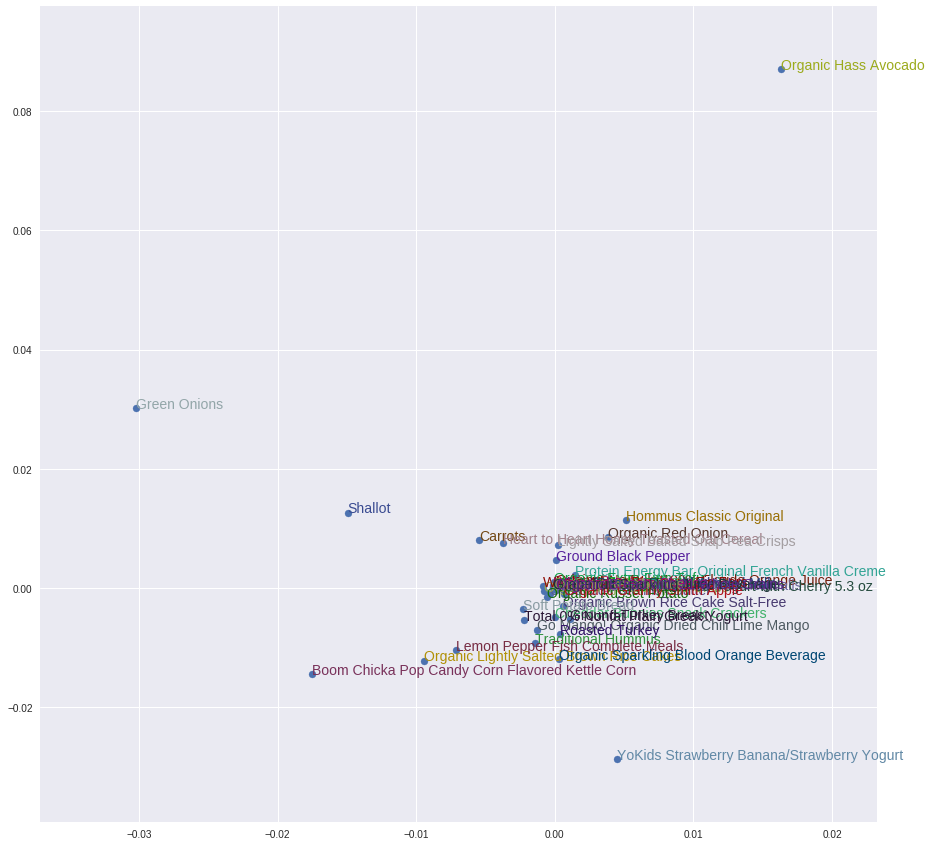

In [78]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topProds[start:end], X, Y):
    plt.text(x,y,prod_names()[prod_ratings.product_id[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

## Model: Feed user/prod embedding to a Neural Net

In [19]:
from keras import backend
from keras.callbacks import EarlyStopping

def embedding_input(name, n_in, n_out, reg):
    '''returns input and its embedding using Keras'''
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(input_dim=n_in, output_dim=n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

def rmse(y_true, y_pred):
    '''Define Root Mean Squared Error as a custom metric'''
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

#number of elements in embedding layer (latent factors)
n_factors=5

#get input and embedding for users and products
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-1)
prod_in, p = embedding_input('prod_in', n_prods, n_factors, 1e-1)

#stop training when val_loss starts to increase
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0)]

#model: concat embedding layers and feed to neural net
x = concatenate([u, p], axis=2)
x = Flatten()(x)
x = Dropout(0.8)(x)
x = BatchNormalization()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.8)(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = Dropout(0.8)(x)
x = BatchNormalization()(x)
x = Dense(5, activation='relu')(x)
x = Dropout(0.8)(x)
x = BatchNormalization()(x)
x = Dense(1)(x)
nn = Model([user_in, prod_in], x)
nn.compile(optimizer=Adam(0.001), loss='mse', metrics=[rmse])

In [20]:
history = nn.fit([prod_ratings.user_id, prod_ratings.product_id], prod_ratings.product_score, batch_size=64,
       epochs=100, validation_split=0.1, verbose =1, callbacks=callbacks)

#plt.plot(history.history['val_loss'])

Train on 12477371 samples, validate on 1386375 samples
Epoch 1/100
12477371/12477371 [==============================] - 2848s - loss: 0.8169 - rmse: 0.6167 - val_loss: 0.7898 - val_rmse: 0.6153
Epoch 2/100
12477371/12477371 [==============================] - 2838s - loss: 0.7912 - rmse: 0.6156 - val_loss: 0.7891 - val_rmse: 0.6199
Epoch 3/100
12477371/12477371 [==============================] - 2875s - loss: 0.7908 - rmse: 0.6156 - val_loss: 0.7892 - val_rmse: 0.6086
Epoch 4/100
12477371/12477371 [==============================] - 2755s - loss: 0.7907 - rmse: 0.6156 - val_loss: 0.7888 - val_rmse: 0.6118
Epoch 5/100
12477371/12477371 [==============================] - 2776s - loss: 0.7905 - rmse: 0.6155 - val_loss: 0.7887 - val_rmse: 0.6123
Epoch 6/100
12477371/12477371 [==============================] - 2848s - loss: 0.7907 - rmse: 0.6155 - val_loss: 0.7887 - val_rmse: 0.6130
Epoch 7/100
12477371/12477371 [==============================] - 3263s - loss: 0.7905 - rmse: 0.6155 - val_loss

KeyboardInterrupt: 

In [21]:
nn.save_weights('models/nn4.h5')

In [ ]:
nn.load_weights('models/nn4.h5')

In [40]:
#prod id to prod name dictionary:
prod_id2name = pd.Series(prod_ratings.product_name.values, index=prod_ratings.product_id).to_dict()

In [48]:
def predictions_nn(u_id, p_id):
    '''create a product_name:product_score dictionary '''
    return (prod_id2name[p_id], nn.predict([np.array([u_id]), np.array([p_id])])[0][0])

def user_recommendation_nn(u_id):
    '''recommend 20 new products to user'''
    
    #exclude products the user has already bought
    prods_to_rate = list(set(prod_ratings.product_id) - set(prod_ratings[prod_ratings.user_id==u_id].product_id))
    
    #predict the ratings for new unseen products
    scores = {predictions_nn(u_id,p)[0]:predictions_nn(u_id,p)[1] for p in prods_to_rate}
    
    return list(OrderedDict(sorted(scores.items(), key =itemgetter(1), reverse = True)))[:20]

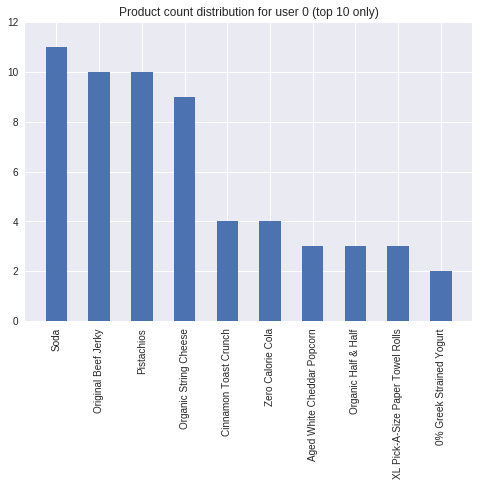

In [49]:
product_dist(0)

In [25]:
user_recommendation_nn(0)

[('100% Mighty Mango Juice Smoothie', 1.4718801),
 ('All Natural Honey Almond Butter', 1.4718801),
 ('Apple Cinnamon Fig Bar', 1.4718801),
 ('Artichoke Spinach Dip', 1.4718801),
 ('Asian Pears', 1.4718801),
 ('Baked Organic Sea Salt Crunchy Pea Snack', 1.4718801),
 ('Banana', 1.4718801),
 ('Birthday Cake Light Ice Cream', 1.4718801),
 ('Black Bean Vegetables Burrito', 1.4718801),
 ('Black Plum', 1.4718801),
 ('Blueberry Yoghurt', 1.4718801),
 ('Broccoli & Cheddar Bake Meal Bowl', 1.4718801),
 ('Brown Rice Black-Eyed Peas and Veggies Bowl', 1.4718801),
 ('Bubblegum Flavor Natural Chewing Gum', 1.4718801),
 ('Carrot Ginger Soup', 1.4718801),
 ('Cheddar Bunnies Snack Crackers', 1.4718801),
 ('Cherry Pomegranate Greek Yogurt', 1.4718801),
 ('Chicken Caesar Salad', 1.4718801),
 ('Chicken Tikka Masala with Cumin Infused Basmati Rice Frozen Meal',
  1.4718801),
 ('Chipotle Beef & Pork Realstick', 1.4718801)]

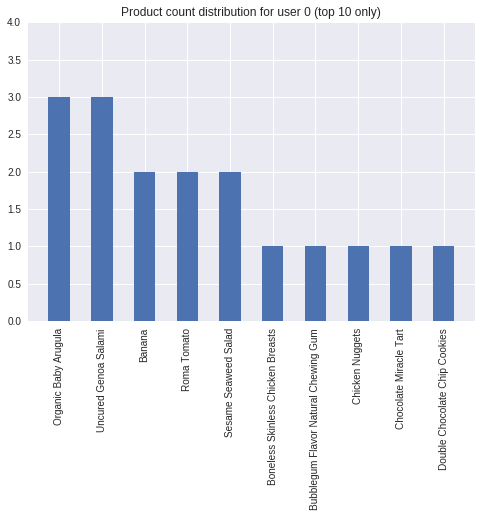

In [28]:
product_dist(99)

In [26]:
user_recommendation_nn(99)

[('0% Greek Strained Yogurt', 1.4718801),
 ('Aged White Cheddar Popcorn', 1.4718801),
 ('Bag of Organic Bananas', 1.4718801),
 ('Bartlett Pears', 1.4718801),
 ('Cinnamon Toast Crunch', 1.4718801),
 ('Creamy Almond Butter', 1.4718801),
 ('Honeycrisp Apples', 1.4718801),
 ('Milk Chocolate Almonds', 1.4718801),
 ('Organic Fuji Apples', 1.4718801),
 ('Organic Half & Half', 1.4718801),
 ('Organic String Cheese', 1.4718801),
 ('Organic Unsweetened Almond Milk', 1.4718801),
 ('Organic Unsweetened Vanilla Almond Milk', 1.4718801),
 ('Organic Whole Milk', 1.4718801),
 ('Original Beef Jerky', 1.4718801),
 ('Pistachios', 1.4718801),
 ('Soda', 1.4718801),
 ('XL Pick-A-Size Paper Towel Rolls', 1.4718801),
 ('Zero Calorie Cola', 1.4718801),
 ('100% Mighty Mango Juice Smoothie', 1.4718801)]

## Analyze results

For simplicity, we restrict the analysis to the top 2000 most popular products.

In [82]:
g_names=prod_ratings.groupby(['product_name'])['product_count'].sum()
g=prod_ratings.groupby(['product_id'])['product_count'].sum()

topProds_names = g_names.sort_values(ascending=False)[:2000]
topProds=g.sort_values(ascending=False)[:2000]
topProds = np.array(topProds.index)

In [84]:
#Here are the top 20 prod by name
topProds_names[:20]

product_name
Banana                      491291
Bag of Organic Bananas      394930
Organic Strawberries        275577
Organic Baby Spinach        251705
Organic Hass Avocado        220877
Organic Avocado             184224
Large Lemon                 160792
Strawberries                149445
Limes                       146660
Organic Whole Milk          142813
Organic Raspberries         142603
Organic Yellow Onion        117716
Organic Garlic              113936
Organic Zucchini            109412
Organic Blueberries         105026
Cucumber Kirby               99728
Organic Fuji Apple           92889
Organic Lemon                91251
Organic Grape Tomatoes       88078
Apple Honeycrisp Organic     87272
Name: product_count, dtype: int64

In [85]:
#Here are their ids
topProds

array([   25,     2,   159, ...,  4297,  2524, 10778])

We can look at the top and bottom rated products and their embeddings

In [75]:
get_prod_emb = Model(prod_in, p)
prod_emb = np.squeeze(get_prod_emb.predict([topProds]))
prod_emb.shape

(2000, 5)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 


In [87]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
prod_pca = pca.fit(prod_emb.T).components_

Here's the 1st component. Hard to tell what these features represent...


In [102]:
c0 = prod_pca[0]
prod_comp = [(c, prod_id2name[i]) for c,i in zip(c0, topProds)]

In [106]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10]

[(0.15483096211102707, '100% Recycled Paper Towels'),
 (0.13612726855216908, 'Milk, Vitamin D'),
 (0.13316449503257716, 'Organic Large Grade A Eggs'),
 (0.13207441506901763, 'Large Grade AA Organic Eggs'),
 (0.11981001063915749, 'Kale & Spinach Superfood Puffs'),
 (0.11981001063915749, 'Spicy Hummus'),
 (0.10189377917844478, 'Cara Cara Navel Orange'),
 (0.096916387942302687, 'Cherry Pomegranate Greek Yogurt'),
 (0.092252645342378259, 'Organic Lactose Free Whole Milk'),
 (0.090317639393340074, 'Sliced Sourdough Bread')]

In [107]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.1475778739052466, 'Total 2% Lowfat Plain Greek Yogurt'),
 (-0.14481574527893071, 'Petit Suisse Fruit'),
 (-0.14481574527893071, 'Lightly Salted Rice Cakes'),
 (-0.14087222597223018, 'Organic Air Chilled Whole Chicken'),
 (-0.13773137170534866, 'Thick & Crispy Tortilla Chips'),
 (-0.13412214880956483, 'Pear & Mango Stage 2 Baby Food'),
 (-0.13398924605557483, 'Unsweetened Almond Milk'),
 (-0.13398924605557483, 'Original Beef Jerky'),
 (-0.13032572885899943, 'Chocolate Peanut Butter Cup Gelato'),
 (-0.1255435435712012, 'Organic White English Muffins')]

Here's the 2nd component

In [108]:
c1 = prod_pca[1]
prod_comp = [(c, prod_id2name[i]) for c,i in zip(c1, topProds)]

In [109]:
sorted(prod_comp, key=itemgetter(0),reverse=True)[:10]

[(0.21859038069024433, 'Semi-Sweet Chocolate Premium Baking Chips'),
 (0.14147974778116565, 'Cage Free Brown Eggs-Large, Grade A'),
 (0.12989311011684268, 'Lemon Lime Thirst Quencher'),
 (0.12989311011684268, '70% Dark Chocolate Salted Almond Bar'),
 (0.12856463475013274, 'Grilled Chicken Breast Strips'),
 (0.12459902094336009, 'Fruit Punch Sports Drink'),
 (0.11761902277550082, 'Smoked Turkey Breast Slices'),
 (0.11485107218951596, 'Canned Aranciata Orange'),
 (0.11393950537569207, 'Organic YoKids Very Berry Smoothies'),
 (0.11118859748767392, 'Dairy Free Unsweetened Vanilla Coconut Milk')]

In [110]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.14266125510546629, 'Organic Australian Style Vanilla Lowfat Yogurt'),
 (-0.13364401270878642, 'All Natural Marinara Sauce'),
 (-0.12685217902382068, 'Whole Hearts of Palm'),
 (-0.12685217902382068, 'Original Roasted Seaweed Snacks'),
 (-0.12685217902382068, 'Power Grains Waffles 6 ct'),
 (-0.12410139278757265, 'Traditional Favorites Tomato & Basil Pasta Sauce'),
 (-0.12410139278757265, 'Sea Salt Made With Organic Grain Rice Chips'),
 (-0.11930182406585188, 'Sweet Baguette'),
 (-0.11291793646265734, 'Organic Apple Juice'),
 (-0.1115673626045055, 'Lactose Free 2% Reduced Fat Milk')]

Here's the 3rd component

In [111]:
c2 = prod_pca[2]
prod_comp = [(c, prod_id2name[i]) for c,i in zip(c2, topProds)]

In [112]:
sorted(prod_comp, key=itemgetter(0),reverse=True)[:10]

[(0.15922550253698031, 'Gala Apples'),
 (0.14917539074052383, 'Lemon Hummus'),
 (0.14706261587946901, 'Reduced Fat 2% Milk'),
 (0.14688199269880578, 'Sustainably Soft Bath Tissue'),
 (0.13504192843320212, 'Strawberry Flavored Organic Z Fruit Rope'),
 (0.12604081795927774, 'Blood Orange Italian Soda'),
 (0.10749824997436265, 'Organic Pinto Beans'),
 (0.10490779942135213, 'Lemon Lime Thirst Quencher'),
 (0.10490779942135213, '70% Dark Chocolate Salted Almond Bar'),
 (0.10294036825548405, 'Extralean Ground Turkey Breast')]

In [113]:
sorted(prod_comp, key=itemgetter(0))[:10]

[(-0.15773329586238416, 'Select-A-Size White Paper Towels'),
 (-0.14754491866795694, 'Pink Lady Apple Kombucha'),
 (-0.13795691456246365, 'Apple and Carrot Stage 2 Baby Food'),
 (-0.12907142451422335, 'Salted Tub of Butter'),
 (-0.11507420827434961, 'Classic Hummus'),
 (-0.11505939207301218, 'Whole Wheat Crackers'),
 (-0.10913640296433386, 'Unsweetened Blackberry Water'),
 (-0.10913640296433386, 'Annie Peely Fruit 4.5 Z'),
 (-0.10707321910730118, 'Crunchy Peanut Butter Energy Bar'),
 (-0.10400664765467768,
  'Stage 1 Apples & Strawberries Organic Pureed Baby Food')]

We can draw a picture to see how various products appear on the map of these components. This picture shows the 1st and 3rd components.

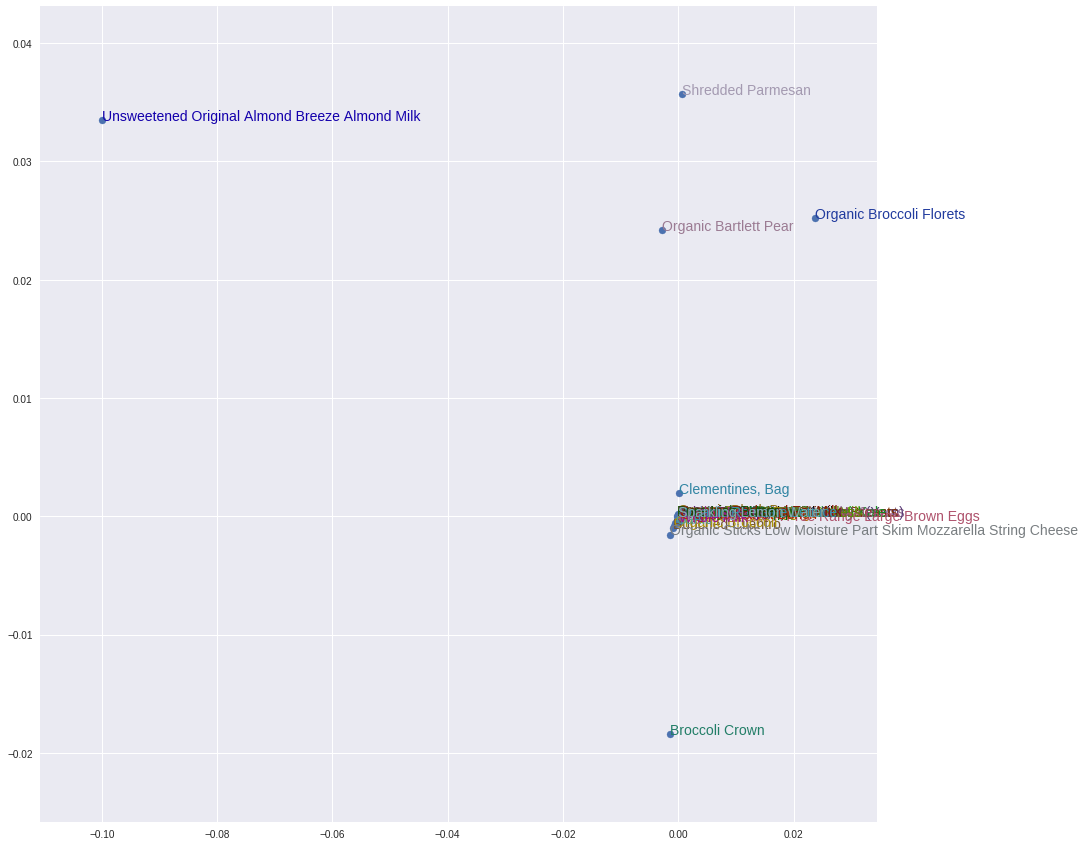

In [114]:
start=50; end=100
X = c0[start:end]
Y = c2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)

for i, x, y in zip(topProds[start:end], X, Y):
    plt.text(x,y,prod_id2name[i], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()